# Assignment 3

# Instructions

1. You have to use only this notebook for all your code.
2. All the results and plots should be mentioned in this notebook.
3. For final submission, submit this notebook along with the report ( usual 2-4 pages, latex typeset, which includes the challenges faces and details of additional steps, if any)
4. Marking scheme
    -  **60%**: Your code should be able to detect bounding boxes using resnet 18, correct data loading and preprocessing. Plot any 5 correct and 5 incorrect sample detections from the test set in this notebook for both the approached (1 layer and 2 layer detection), so total of 20 plots.
    -  **20%**: Use two layers (multi-scale feature maps) to detect objects independently as in SSD (https://arxiv.org/abs/1512.02325).  In this method, 1st detection will be through the last layer of Resnet18 and the 2nd detection could be through any layer before the last layer. SSD uses lower resolution layers to detect larger scale objects. 
    -  **20%**: Implement Non-maximum suppression (NMS) (should not be imported from any library) on the candidate bounding boxes.
    
5. Report AP for each of the three class and mAP score for the complete test set.

In [0]:
#necessary library
from __future__ import division, print_function, unicode_literals
import numpy as np
import torch
from torch import nn ,optim
import torch.utils.data
import torchvision
import torch.utils.data as data
import torchvision.transforms as transforms
from torchvision import models
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline
plt.ion()
import numpy as np
import os
import cv2
import xml.etree.ElementTree as ET
from PIL import Image
from torchsummary import summary
import cv2
import numpy as np
import PIL
from IPython.display import display

## Build the data
Use the following links to locally download the data:
<br/>Training and validation:
<br/>http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
<br/>Testing data:
<br/>http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
<br/>The dataset consists of images from 20 classes, with detection annotations included. The JPEGImages folder houses the images, and the Annotations folder has the object-wise labels for the objects in one xml file per image. You have to extract the object information, i.e. the [xmin, ymin] (the top left x,y co-ordinates) and the [xmax, ymax] (the bottom right x,y co-ordinates) of only the objects belonging to the three classes(aeroplane, bottle, chair). For parsing the xml file, you can import xml.etree.ElementTree for you. <br/>
<br/> Organize the data as follows:
<br/> For every image in the dataset, extract/crop the object patch from the image one by one using their respective co-ordinates:[xmin, ymin, xmax, ymax], resize the image to resnet_input, and store it with its class label information. Do the same for training/validation and test datasets. <br/>
##### Important
You also have to collect data for an extra background class which stands for the class of an object which is not a part of any of the 20 classes. For this, you can crop and resize any random patches from an image. A good idea is to extract patches that have low "intersection over union" with any object present in the image frame from the 20 Pascal VOC classes. The number of background images should be roughly around those of other class objects' images. Hence the total classes turn out to be four. This is important for applying the sliding window method later.


In [2]:
#mount the google drive
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [3]:
with open('/gdrive/My Drive/foo.txt', 'w') as f:
  f.write('Hello Google Drive!')
!cat '/gdrive/My Drive/foo.txt'

Hello Google Drive!

In [0]:
#load the test data
!tar -xf /gdrive/My\ Drive/VOCtest_06-Nov-2007.tar && mv VOCdevkit VOCdevkit_test
#load the train data
!tar -xf /gdrive/My\ Drive/VOCtrainval_06-Nov-2007.tar && mv VOCdevkit VOCdevkit_train

In [0]:
classes = (
           'aeroplane','background',
           'bottle','chair'
           )

In [0]:
#build the dataset
def build_dataset(data):
  counter =1
  path = '/content/VOCdevkit_'+ data +'/VOC2007/Annotations/'
  img_path = '/content/VOCdevkit_'+data +'/VOC2007/JPEGImages/'
  for filename in os.listdir(path):
    
      if not filename.endswith('.xml'): continue
        
      fullname = os.path.join(path, filename)
      tree = ET.parse(fullname)
      root = tree.getroot()
      length = len(list(root)) - 6
      im = filename
      im =im.replace(".xml",".jpg")
      imagename = os.path.join(img_path, im)
      
      for i in range(length):
        name = root[i+6][0].text
        if name =='aeroplane' or name =="bottle" or name =="chair" :
          x = root[i+6][4][0].text
          y = root[i+6][4][1].text
          z = root[i+6][4][2].text
          w = root[i+6][4][3].text
          img = Image.open(imagename)      
          img2 = img.crop((int(x),int(y),int(z),int(w)))
          new_img_name = str(counter) + '_' + im
          
          if name =='aeroplane':
            img2.save('/content/'+data+'/aeroplane/'+ new_img_name)
          elif name =='bottle':
            img2.save('/content/'+data+'/bottle/' +new_img_name)
          elif name =='chair':
            img2.save('/content/'+data+'/chair/'+ new_img_name)

          counter +=1         

In [0]:
#generate the background data
def build_backgound(data):
  counter =1
  path = '/content/VOCdevkit_'+data+'/VOC2007/Annotations/'
  img_path = '/content/VOCdevkit_'+data+'/VOC2007/JPEGImages/'
  for filename in os.listdir(path):
      if(counter > 1500):break

      if not filename.endswith('.xml'): continue 

      fullname = os.path.join(path, filename)
      tree = ET.parse(fullname)
      root = tree.getroot()
      width_img = root[4][0].text
      height_img = root[4][1] .text

      for x in range(1):
        #generate random coordinate of images 
        rand_x= np.random.randint(int(width_img)-70)
        rand_y = np.random.randint(int(height_img)-70)
        im = filename
        tmp =0
        im =im.replace(".xml",".jpg")
        imagename = os.path.join(img_path, im)
        img = Image.open(imagename)

        #iterate over all object in images
        for obj in root.findall('object'):

          #iterate over all bndbox in object
          for bndbox in obj.findall('bndbox'):
            x=int(bndbox[0].text)
            y=int(bndbox[1].text)
            z=int(bndbox[2].text)
            w=int(bndbox[3].text)
            x1 = max(rand_x, x)
            y1 = max(rand_y, y)
            x2 = min(rand_x +70, z)
            y2 = min(rand_y+70, w)

            # AREA OF OVERLAP - Area where the boxes intersect
            width = (x2 - x1)
            height = (y2 - y1)
            # handle case where there is NO overlap
            area_overlap = width * height
            # COMBINED AREA
            area_a = 4900
            area_b = (z - x) * (w - y)
            area_combined = area_a + area_b - area_overlap
            epsilon=1e-5
            # RATIO OF AREA OF OVERLAP OVER COMBINED AREA
            iou = area_overlap / (area_combined+epsilon)

            #itersection over union check
            if(iou < 0.2 and iou >0.0 ):
              img2 = img.crop((rand_x,rand_y,rand_x + 70 ,rand_y +70))
              new_img_name = 'b'+'_'+str(counter) + '_' + im
              img2.save('/content/'+data+'/background/'+ new_img_name)
              counter +=1
            else:
              tmp =1
              break
          if(tmp==1):break

In [0]:
#generate test and train data
build_dataset('train')
build_dataset('test')
build_backgound('train')
build_backgound('test')


## Load the Data
<br/>You can train the network on the created dataset. This will yield a classification network on the 4 classes of the VOC dataset. 

In [0]:
# Choose your hyper-parameters using validation data
batch_size = 200
num_epochs = 5
learning_rate =  0.001
hyp_momentum = 0.9
TRANSFORM_IMG = transforms.Compose([
    transforms.CenterCrop(256),
    transforms.RandomHorizontalFlip(),
    transforms.Scale((224,224)),
    transforms.ToTensor()
    ])

#Load the train data
train_data = torchvision.datasets.ImageFolder(root='/content/train/', transform=TRANSFORM_IMG)
train_data_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True,  num_workers=4)

#Load the test data
test_data = torchvision.datasets.ImageFolder(root='/content/test/', transform=TRANSFORM_IMG)
test_data_loader  = data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4) 

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:208: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [0]:
#label index of classes
train_data.class_to_idx

{'aeroplane': 0, 'background': 1, 'bottle': 2, 'chair': 3}

### Fine-tuning
Use the pre-trained network to fine-tune the network in the following section:

# Train the network

In [0]:
#setting up device 
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
model = models.resnet18(pretrained=True).to(device)
for param in model.parameters():
    param.requires_grad = False
  
#adding parameter in resnet 18
model.fc = nn.Sequential(nn.Linear(512, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 4),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
model.to(device)
summary(model,(3,224,224))

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth
46827520it [00:00, 79018562.27it/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [0]:
#training single layer model1
epochs = 10
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []
for epoch in range(epochs):
    for inputs, labels in train_data_loader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward() 
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in test_data_loader:
                    inputs, labels = inputs.to(device),labels.to(device)
                          
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(train_data_loader))
            test_losses.append(test_loss/len(test_data_loader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(test_data_loader):.3f}.. "
                  f"Test accuracy: {accuracy/len(test_data_loader):.3f}")
            running_loss = 0
            model.train()

Epoch 1/10.. Train loss: 0.988.. Test loss: 1.124.. Test accuracy: 0.454
Epoch 1/10.. Train loss: 0.622.. Test loss: 0.665.. Test accuracy: 0.715
Epoch 2/10.. Train loss: 0.466.. Test loss: 0.535.. Test accuracy: 0.796
Epoch 2/10.. Train loss: 0.430.. Test loss: 0.416.. Test accuracy: 0.849
Epoch 3/10.. Train loss: 0.390.. Test loss: 0.424.. Test accuracy: 0.844
Epoch 3/10.. Train loss: 0.365.. Test loss: 0.383.. Test accuracy: 0.862
Epoch 4/10.. Train loss: 0.339.. Test loss: 0.386.. Test accuracy: 0.856
Epoch 4/10.. Train loss: 0.328.. Test loss: 0.365.. Test accuracy: 0.864
Epoch 5/10.. Train loss: 0.310.. Test loss: 0.394.. Test accuracy: 0.858
Epoch 5/10.. Train loss: 0.373.. Test loss: 0.451.. Test accuracy: 0.825
Epoch 6/10.. Train loss: 0.361.. Test loss: 0.378.. Test accuracy: 0.867
Epoch 6/10.. Train loss: 0.321.. Test loss: 0.385.. Test accuracy: 0.853
Epoch 7/10.. Train loss: 0.331.. Test loss: 0.438.. Test accuracy: 0.832
Epoch 7/10.. Train loss: 0.318.. Test loss: 0.362..

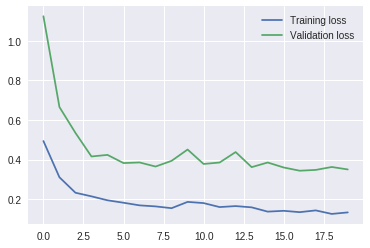

In [0]:
torch.save(model, ' model1')
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [0]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)

In [0]:
#Paramenter of 2layer models
model2 = models.resnet18(pretrained=True).to(device)
list(model2.modules()) # to inspect the modules of your model
newmodel = torch.nn.Sequential(*(list(model2.children())[:-3]))
for param in newmodel.parameters():
    param.requires_grad = False
#adding parameter in resnet 18
newmodel.fc = nn.Sequential(Flatten(),nn.Linear(50176, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 4),
                                 nn.LogSoftmax(dim=1))
criterion2 = nn.NLLLoss()
optimizer2 = optim.Adam(newmodel.fc.parameters(), lr=0.001)
newmodel.to(device)
summary(newmodel,(3,224,224))

In [0]:
#training 2 layer model
epochs = 5
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []
for epoch in range(epochs):
    for inputs, labels in train_data_loader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer2.zero_grad()
        logps = newmodel.forward(inputs)
        loss = criterion2(logps, labels)
        loss.backward()
        optimizer2.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            newmodel.eval()
            with torch.no_grad():
                for inputs, labels in test_data_loader:
                    inputs, labels = inputs.to(device),labels.to(device)
                          
                    logps = newmodel.forward(inputs)
                    batch_loss = criterion2(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(train_data_loader))
            print(len(train_data_loader))
            test_losses.append(test_loss/len(test_data_loader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(test_data_loader):.3f}.. "
                  f"Test accuracy: {accuracy/len(test_data_loader):.3f}")
            running_loss = 0
            newmodel.train()

In [0]:
torch.save(newmodel, ' model2')
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

# Testing and Accuracy Calculation
For applying detection, use a slding window method to test the above trained trained network on the detection task:<br/>
Take some windows of varying size and aspect ratios and slide it through the test image (considering some stride of pixels) from left to right, and top to bottom, detect the class scores for each of the window, and keep only those which are above a certain threshold value. There is a similar approach used in the paper -Faster RCNN by Ross Girshick, where he uses three diferent scales/sizes and three different aspect ratios, making a total of nine windows per pixel to slide. You need to write the code and use it in testing code to find the predicted boxes and their classes.

In [0]:
#sliding window implementation
def sliding_window(image, stepSize, windowSize):
    # slide a window across the image
	for y in range(0, image.shape[0], stepSize):
		for x in range(0, image.shape[1], stepSize):
			# yield the current window
			yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])
def cv2_imshow(a):
  """A replacement for cv2.imshow() for use in Jupyter notebooks."""
  a = a.clip(0, 255).astype('uint8')
  # cv2 stores colors as BGR; convert to RGB
  if a.ndim == 3:
    if a.shape[2] == 4:
      a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
    else:
      a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
  display(PIL.Image.fromarray(a))

In [0]:
def IOU(boxa ,boxb):
  x1 = max(boxa[0], boxb[0])
  y1 = max(boxa[1], boxb[1])
  x2 = min(boxa[2], boxb[2])
  y2 = min(boxa[3], boxb[3])

  # AREA OF OVERLAP - Area where the boxes intersect
  width = (x2 - x1)
  height = (y2 - y1)
  # handle case where there is NO overlap
  area_overlap = width * height
  # COMBINED AREA
  area_a = (boxa[2] -boxa[0])*(boxa[3] - boxa[1])
  area_b = (boxb[2] -boxb[0])*(boxb[3] - boxb[1])
  area_combined = area_a + area_b - area_overlap
  epsilon=1e-5
  # RATIO OF AREA OF OVERLAP OVER COMBINED AREA
  iou = area_overlap /(float(area_combined+epsilon))
  return iou

In [0]:
#load single layer model
model=torch.load('/gdrive/My\ Drive/model1')
#load 2 layer model
newmodel=torch.load('/gdrive/My\ Drive/model2')
#Accuracy of Model1
total_images = 0
model.eval()
sum = 0

for inputs, labels in test_data_loader:
    inputs, labels = inputs.to(device),labels.to(device)
    outputs = model(inputs)
    prob = torch.exp(outputs)
    _, preds = torch.max(outputs, 1)
    correct = torch.sum(preds == labels)

    total_images += inputs.size(0)

    sum += correct.item()
        
print('Correct Predicted image for singla layer model',sum)
print('Total Image',total_images)
print("Accuracy is")
print(sum / total_images)

Correct Predicted image 3374
Total Image 3842
Accuracy is
0.8781884435190005


In [40]:
import cv2
img_transform = transforms.Compose([
    transforms.CenterCrop(256),
    transforms.RandomHorizontalFlip(),
    transforms.Scale((224,224)),
    transforms.ToTensor()
    ])

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:208: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


Apply non_maximum_supression to reduce the number of boxes. You are free to choose the threshold value for non maximum supression, but choose wisely [0,1].

In [0]:
def non_maximum_supression(p_boxes,threshold = 0.01):
	# if there are no boxes, return an empty list
  
  if (len(p_boxes) == 0):
	  return []
 
  boxes = p_boxes[:,:-1]
  
	# initialize the list of picked indexes	
 
  pick = []
 
	# grab the coordinates of the bounding boxes
  boxes = np.asarray(boxes)
  x1 = boxes[:,0]
  y1 = boxes[:,1]
  x2 = boxes[:,2]
  y2 = boxes[:,3]

  # compute the area of the bounding boxes and sort the bounding
  # boxes by the bottom-right y-coordinate of the bounding box
  area = (x2 - x1 + 1) * (y2 - y1 + 1)
  idxs = np.argsort(y2)

  # keep looping while some indexes still remain in the indexes
  # list
  while len(idxs) > 0:
    # grab the last index in the indexes list and add the
    # index value to the list of picked indexes
    last = len(idxs) - 1
    i = idxs[last]
    pick.append(i)

    # find the largest (x, y) coordinates for the start of
    # the bounding box and the smallest (x, y) coordinates
    # for the end of the bounding box
    xx1 = np.maximum(x1[i], x1[idxs[:last]])
    yy1 = np.maximum(y1[i], y1[idxs[:last]])
    xx2 = np.minimum(x2[i], x2[idxs[:last]])
    yy2 = np.minimum(y2[i], y2[idxs[:last]])

    # compute the width and height of the bounding box
    w = np.maximum(0, xx2 - xx1 + 1)
    h = np.maximum(0, yy2 - yy1 + 1)

    # compute the ratio of overlap
    overlap = (w * h) / area[idxs[:last]]

    # delete all indexes from the index list that have
    idxs = np.delete(idxs, np.concatenate(([last],
      np.where(overlap > threshold)[0])))

  # return only the bounding boxes that were picked using the
  # integer data type
  return p_boxes[pick]

In [0]:
#Generating test Data set for object detection
counter =1
path = '/content/VOCdevkit_test/VOC2007/Annotations/'
img_path = '/content/VOCdevkit_test/VOC2007/JPEGImages/'
for filename in os.listdir(path):
    if not filename.endswith('.xml'): continue
    fullname = os.path.join(path, filename)
    tree = ET.parse(fullname)
    root = tree.getroot()
    length = len(list(root)) - 6
    im = filename
    im =im.replace(".xml",".jpg")
    imagename = os.path.join(img_path, im)

    for i in range(length):
      name = root[i+6][0].text     
      if name =='aeroplane' or name =="bottle" or name =="chair" :
        img = Image.open(imagename)      
#           if name =='aeroplane':
#             new_img_name = 'aeroplane'str(counter) + '_' + im
#           elif name =='bottle':
#             new_img_name = str(counter) + '_' + im
#           elif name =='chair':
        new_img_name = str(counter) + '_' + im
        img.save('/content/final_test/'+ new_img_name)
        counter +=1    
        break;


In [0]:
def get_g_truth(path , type):
  tree = ET.parse(path)
  root = tree.getroot()
  length = len(list(root)) - 6
#   im = filename
#   im =im.replace(".xml",".jpg")
#   imagename = os.path.join(img_path, im)
  coordinates= []
  for i in range(length):
    name = root[i+6][0].text
    if name ==type :
      x = int(root[i+6][4][0].text)
      y =int(root[i+6][4][1].text)
      z = int(root[i+6][4][2].text)
      w = int(root[i+6][4][3].text)
      coordinates.append([x,y,z,w])
  
  return np.asarray(coordinates)
#       img = Image.open(imagename)      
#       img2 = img.crop((int(x),int(y),int(z),int(w)))
#       new_img_name = str(counter) + '_' + im
        
  
    
  
  

In [0]:
# Detect objects on testdata

! rm object_count.txt aeroplane.txt bottle.txt chair.txt
! touch object_count.txt aeroplane.txt bottle.txt chair.txt
object_count = [0,0,0]

xml_root = '/content/final_test/xml/'
img_path = '/content/final_test/img/'
for filename in os.listdir(img_path):
#     if not filename.endswith('.xml'): continue
#     fullname = os.path.join(img_path, filename)
    imagename = os.path.join(img_path, filename)
    aeroplane=[]
    bottle=[]
    chair=[]
    image_read = cv2.imread(imagename)
#     print(filename)
    all_windows = [(128,128),(64,64),(64,128),(128,64),(256,256)]
    for winW, winH in all_windows:
      for (x, y, window) in sliding_window(image_read, stepSize=20, windowSize=(winW, winH)):
        # if the window does not meet our desired window size, ignore it
        if window.shape[0] != winH or window.shape[1] != winW:
          continue
        patch = Image.fromarray(window)    
        inputs = img_transform(patch).view(1,3,224,224).cuda()
        outputs = model(inputs)
        prob = torch.exp(outputs)
        _, preds = torch.max(outputs, 1)
        max_prob = torch.max(prob).item()
        if(preds.item()!=1 and max_prob >=0.95):
#           cv2.rectangle(p_image, (x, y), (x + winW, y + winH), (0, 255, 0), 2)
          box = [x, y, x + winW,y + winH,max_prob]
          box = np.asarray(box)
          if (preds == 0):
            aeroplane.append(box)
          elif (preds == 2):
            bottle.append(box)
          else :
            chair.append(box)
    bottle=non_maximum_supression(bottle)
    chair=non_maximum_supression(chair)
    aeroplane=non_maximum_supression(aeroplane)
    # change in nms
    img_xml_path =  xml_root + filename.split('.')[0]+'.xml'
    
    # aero
    g_aero = get_g_truth(img_xml_path, 'aeroplane')
    aero_truthness = check_truthness(aeroplane, g_aero, 0.5)
    if len(aero_truthness) > 0:
        with open('aerplane.txt', 'a') as f:
            np.savetxt(f, aero_truthness)
        object_count[0]+=len(aero_truthness)
    
    # bottle
    g_bottle = get_g_truth(img_xml_path, 'bottle')
    bottle_truthness = check_truthness(bottle, g_bottle, 0.5)
    if len(bottle_truthness) > 0:
        with open('bottle.txt', 'a') as f:
            np.savetxt(f, bottle_truthness)
        object_count[1]+= len(bottle_truthness)
            
    # bottle
    g_chair = get_g_truth(img_xml_path, 'chair')
    chair_truthness = check_truthness(chair, g_chair, 0.5)
    if len(chair_truthness) > 0:
        with open('chair.txt', 'a') as f:
            np.savetxt(f, chair_truthness)
        object_count[2]+=len(chair_truthness)
        
    clone = image_read.copy()
#     print(len(bottle))
    for box in list(bottle):
      x1 = int(box[0])
      y1 = int(box[1])
      x2 = int(box[2])
      y2 = int(box[3])
      cv2.rectangle(clone, (x1, y1), (x2, y2), (0, 255, 0), 2)
    for box in list(aeroplane):
      x1 = int(box[0])
      y1 = int(box[1])
      x2 = int(box[2])
      y2 = int(box[3])
      cv2.rectangle(clone, (x1, y1), (x2, y2), (255, 0, 0), 2)
    for box in list(chair):
      x1 = int(box[0])
      y1 = int(box[1])
      x2 = int(box[2])
      y2 = int(box[3])
      cv2.rectangle(clone, (x1, y1), (x2, y2), (0, 0, 255), 2)
#     cv2_imshow(clone)
    clone = clone.clip(0, 255).astype('uint8')
  # cv2 stores colors as BGR; convert to RGB
    if clone.ndim == 3:
      if clone.shape[2] == 4:
        clone = cv2.cvtColor(clone, cv2.COLOR_BGRA2RGBA)
      else:
        clone = cv2.cvtColor(clone, cv2.COLOR_BGR2RGB)
    (PIL.Image.fromarray(clone)).save('/content/model1_output/'+filename)
    
with open('object_count.txt','wb') as f:
  np.savetxt(f,object_count)

calculate_map()

In [0]:
# Detect objects on testdata with model2

! rm object_count.txt aeroplane.txt bottle.txt chair.txt
! touch object_count.txt aeroplane.txt bottle.txt chair.txt
object_count = [0,0,0]

xml_root = '/content/final_test/xml/'
img_path = '/content/final_test/img/'
for filename in os.listdir(img_path):
#     if not filename.endswith('.xml'): continue
#     fullname = os.path.join(img_path, filename)
    imagename = os.path.join(img_path, filename)
    aeroplane= []
    bottle=[]
    chair=[]
    image_read = cv2.imread(imagename)
#     print(filename)
    all_windows = [(128,128),(64,64),(64,128),(128,64),(256,256)]
    for winW, winH in all_windows:
      for (x, y, window) in sliding_window(image_read, stepSize=20, windowSize=(winW, winH)):
        # if the window does not meet our desired window size, ignore it
        if window.shape[0] != winH or window.shape[1] != winW:
          continue
        patch = Image.fromarray(window)    
        inputs = img_transform(patch).view(1,3,224,224).cuda()
        outputs2 = model(inputs)
        outputs = newmodel(inputs)
        prob = torch.exp(outputs)
        _, preds = torch.max(outputs, 1)
        max_prob = torch.max(prob).item()
        
        prob2 = torch.exp(outputs2)
        _, preds2 = torch.max(outputs2, 1)
        max_prob2 = torch.max(prob2).item()
        if(preds2.item()!=1 and max_prob2 >=0.95):
#           cv2.rectangle(p_image, (x, y), (x + winW, y + winH), (0, 255, 0), 2)
          box = [x, y, x + winW,y + winH,max_prob2]
          box = np.asarray(box)
          if (preds2 == 0):
            aeroplane.append(box)
          elif (preds2 == 2):
            bottle.append(box)
          else :
            chair.append(box)
        if(preds.item()!=1 and max_prob >=0.95):
#           cv2.rectangle(p_image, (x, y), (x + winW, y + winH), (0, 255, 0), 2)
          box = [x, y, x + winW,y + winH,max_prob]
          box = np.asarray(box)
          if (preds == 0):
            aeroplane.append(box)
          elif (preds == 2):
            bottle.append(box)
          else :
            chair.append(box)
    bottle=non_maximum_supression(bottle)
    chair=non_maximum_supression(chair)
    aeroplane=non_maximum_supression(aeroplane)
    # change in nms
    img_xml_path =  xml_root + filename.split('.')[0]+'.xml'
    
    # aero
    g_aero = get_g_truth(img_xml_path, 'aeroplane')
    aero_truthness = check_truthness(aeroplane, g_aero, 0.5)
    if len(aero_truthness) > 0:
        with open('aerplane.txt', 'a') as f:
            np.savetxt(f, aero_truthness)
        object_count[0]+=len(aero_truthness)
    
    # bottle
    g_bottle = get_g_truth(img_xml_path, 'bottle')
    bottle_truthness = check_truthness(bottle, g_bottle, 0.5)
    if len(bottle_truthness) > 0:
        with open('bottle.txt', 'a') as f:
            np.savetxt(f, bottle_truthness)
        object_count[1]+= len(bottle_truthness)
            
    # bottle
    g_chair = get_g_truth(img_xml_path, 'chair')
    chair_truthness = check_truthness(chair, g_chair, 0.5)
    if len(chair_truthness) > 0:
        with open('chair.txt', 'a') as f:
            np.savetxt(f, chair_truthness)
        object_count[2]+=len(chair_truthness)
        
    clone = image_read.copy()
#     print(len(bottle))
    for box in list(bottle):
      x1 = int(box[0])
      y1 = int(box[1])
      x2 = int(box[2])
      y2 = int(box[3])
      cv2.rectangle(clone, (x1, y1), (x2, y2), (0, 255, 0), 2)
    for box in list(aeroplane):
      x1 = int(box[0])
      y1 = int(box[1])
      x2 = int(box[2])
      y2 = int(box[3])
      cv2.rectangle(clone, (x1, y1), (x2, y2), (255, 0, 0), 2)
    for box in list(chair):
      x1 = int(box[0])
      y1 = int(box[1])
      x2 = int(box[2])
      y2 = int(box[3])
      cv2.rectangle(clone, (x1, y1), (x2, y2), (0, 0, 255), 2)
#     cv2_imshow(clone)
    clone = clone.clip(0, 255).astype('uint8')
  # cv2 stores colors as BGR; convert to RGB
    if clone.ndim == 3:
      if clone.shape[2] == 4:
        clone = cv2.cvtColor(clone, cv2.COLOR_BGRA2RGBA)
      else:
        clone = cv2.cvtColor(clone, cv2.COLOR_BGR2RGB)
    (PIL.Image.fromarray(clone)).save('/content/model1_output/'+filename)
    
with open('object_count.txt','wb') as f:
  np.savetxt(f,object_count)

calculate_map()

#Correct object detection from single layer model

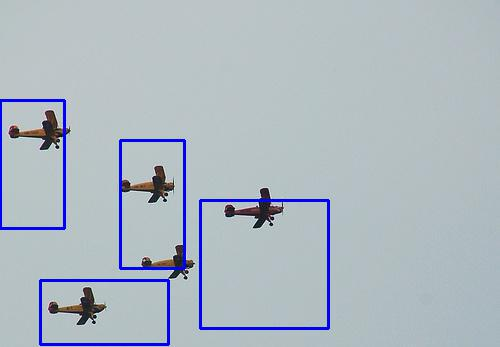

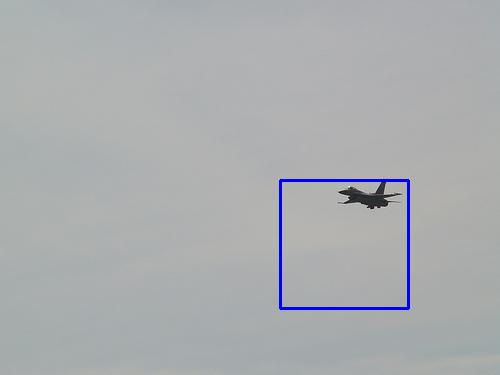

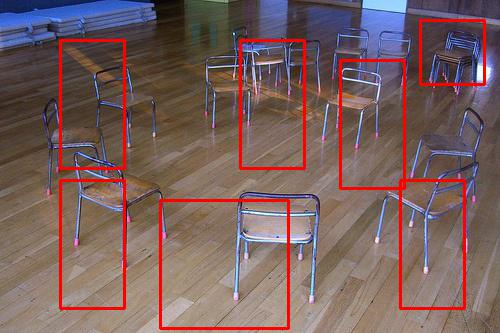

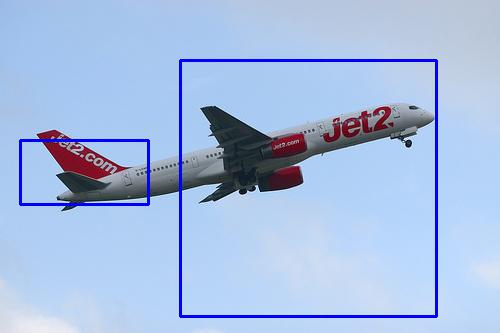

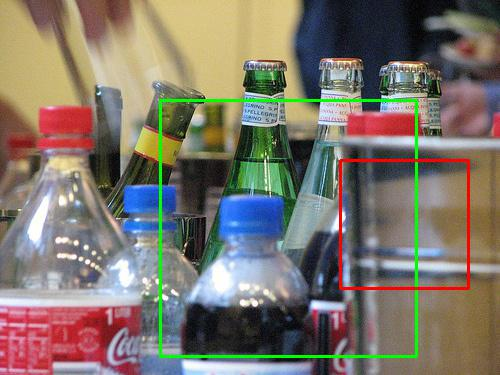

In [22]:
correct_detected = ['503_000706.jpg' , '730_000316.jpg' ,'183_005665.jpg','743_009167.jpg','684_005635.jpg']
incorrect_detected = ['50_004717.jpg' ,'49_008104.jpg' ,'48_002951.jpg' ,'47_006644.jpg','56_004780.jpg']

for images in correct_detected:
  image_read = cv2.imread('/content/' + images)
  cv2_imshow(image_read)
  

#Incorrect object detection from singla layer model

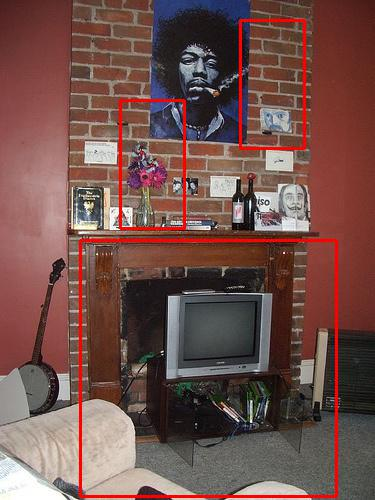

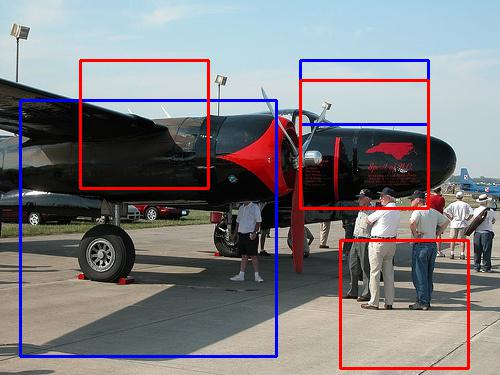

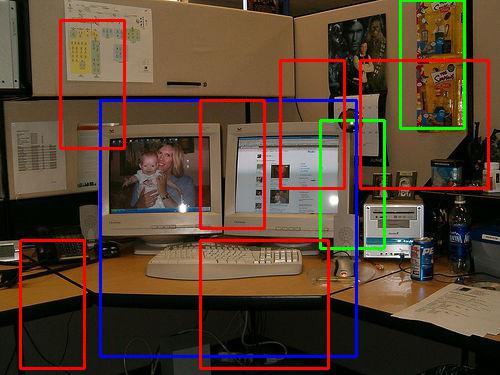

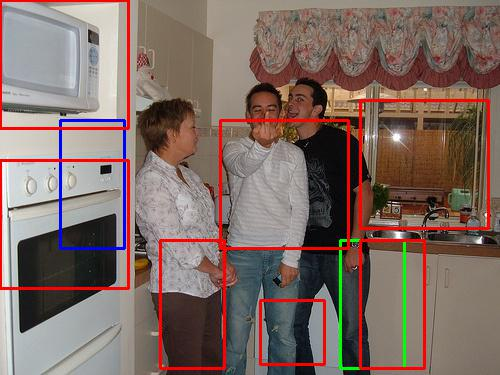

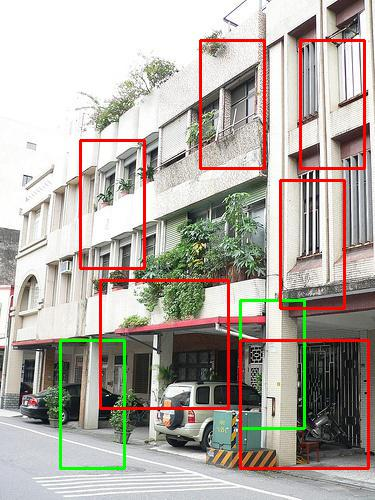

In [23]:

for images in incorrect_detected:
  image_read = cv2.imread('/content/' + images)
  cv2_imshow(image_read)

#Correct object detection from 2Layer model

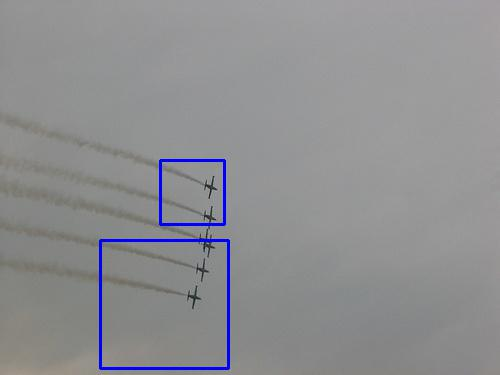

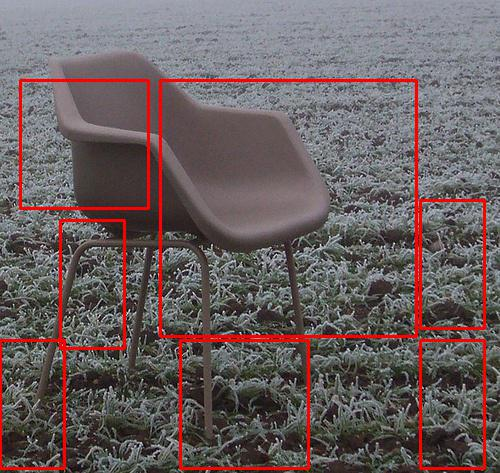

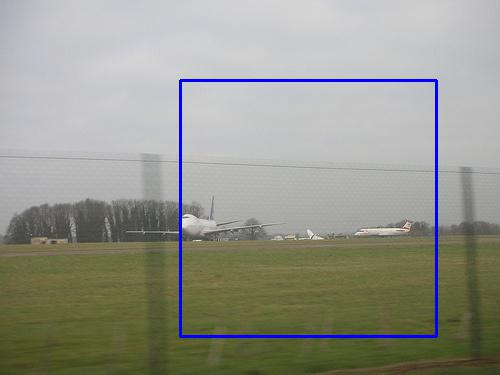

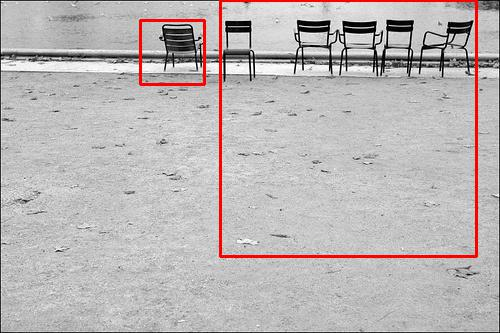

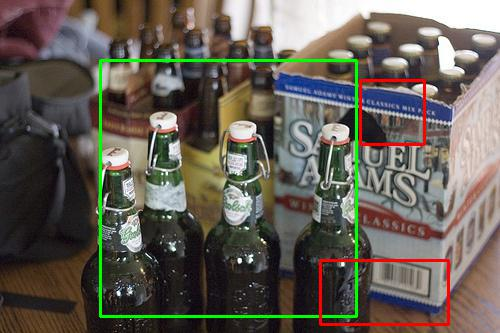

In [24]:
correct_detected = ['103_004377.jpg' , '41_008394.jpg' ,'858_005106.jpg','85_005858.jpg','906_004236.jpg']
incorrect_detected = ['291_006713.jpg' ,'308_003541.jpg' ,'839_000128.jpg' ,'851_004892.jpg','89_005926.jpg']

for images in correct_detected:
  image_read = cv2.imread('/content/' + images)
  cv2_imshow(image_read)
  

#Incorrect object detection from 2layer model


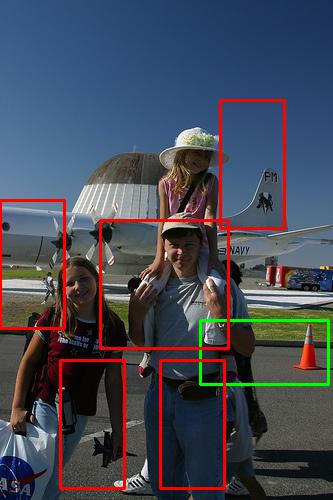

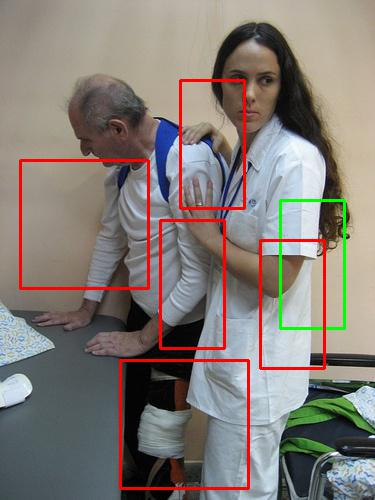

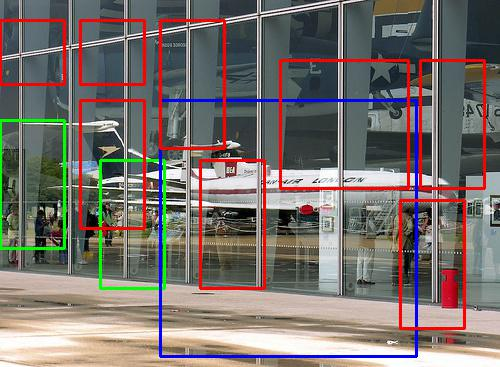

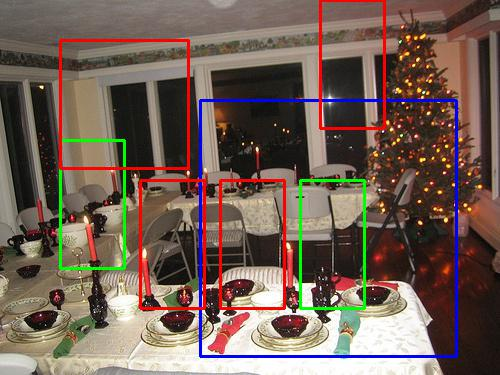

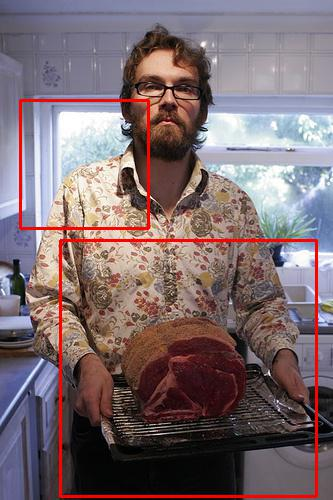

In [25]:

for images in incorrect_detected:
  image_read = cv2.imread('/content/' + images)
  cv2_imshow(image_read)

In [0]:
def check_truthness(pred_boxes_, t_boxes, thres):
  
    if len(t_boxes)==0 or len(pred_boxes_)==0:
        return []

    p_boxes = pred_boxes_[:,:-1]
    
    truth = np.zeros(len(p_boxes), len(t_boxes))
    
    # temp stores TP/FP information of predicted boxes
    temp = []
    
    for i in range(0,len(p_boxes)):
        for j in range(0,len(t_boxes)):
            truth[i,j] = IoU(p_boxes[i], t_boxes[j])
    
    while True:  
        prediction = 0
        x,y = np.unravel_index(np.argmax(IoUs, axis=None), IoUs.shape) 
        if truth[x,y] == -1:
            break
        if truth[x,y] < thres:  
            prediction = 1
            
        temp.append([pred_boxes_[x, -1], prediction])
        truth[x,:] = -1
        truth[:,y] = -1

    return np.asarray(temp).astype("float")




def calculate_AP(class_data, object_count):

    data = np.loadtxt(class_data).astype("float")
    
    if(len(data) == 0):
        return 0
    
    data = data[data[:,0].argsort()]
    
    # prs_rec : precision - recall
    prs_rec = np.zeros(data.shape)
    
    truth = 0
    
    for row in range(0,data.shape[0]):
        truth += data[row,1]
        prs_rec[row,0] = truth/(row+1)
        prs_rec[row,1] = truth/object_count
        
    # Distinct Recalls 
    pr, recals = []       
    sr = np.unique(prs_rec[:,1])

    for rec in sr:
        pr.append(np.max(prs_rec[rec == prs_rec[:,1]], axis = 0))
    pr = np.asarray(pr)
    
    for i in range(0, pr.shape[0]-1):
      
        if pr[i+1 , 0] < pr[i, 0]:
            recals.append(i)

    recals.append(p_r_filtered.shape[0]-1)
    
    # Average Precision
    p_r_distinct = pr[unique_recalls]
    
    for row in range(1,p_r_distinct.shape[0]):
        p_r_distinct[row, 1] -= p_r_distinct[row-1, 1]
    
    area  = np.prod(p_r_distinct,axis = 1)
   
    return np.sum(area)
    

def calculate_map():
    obj = np.loadtxt('object_count.txt')
    aeroplane_AP = calculate_AP('aeroplane.txt', obj[0])
    bottle_AP = calculate_AP('bottle.txt', obj[1])
    chair_AP = calculate_AP('chair.txt', obj[2])
    
    mAP = (aeroplane_AP + bottle_AP + chair_AP)/3
    
    print('AP for aeroplane class = ', aeroplane_AP)
    print('AP for bottle class = ', bottle_AP)
    print('AP for chair class = ',chair_AP)
    print('MAP = ', mAP)